## Importing the necessary libraries

In [1]:
import json
import librosa
from sklearn.model_selection import train_test_split
import librosa.display
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Audio Dataset Class

In [2]:
class AudioDataset(Dataset):
    def __init__(self, data_path = None, data = None, segment_len = 1000):
        """
        Initialize the dataset with preprocessed data.
        
        Args:
            data_path (str): Path to the preprocessed `.npz` file containing Mel spectrograms and labels.
            segment_len (int): Fixed length of segments (in time steps) to extract for training.
        """
        # data = np.load(data_path)
        self.mel_specs = data['mel_specs']  # Shape: (n_mels, total_time_steps)
        self.labels = data['labels']  # Shape: (total_time_steps,)
        
        self.segment_len = segment_len

        # Total number of segments that can be extracted from the dataset
        self.num_segments = self.mel_specs.shape[1] // self.segment_len

    def __len__(self):
        """
        Returns the total number of segments in the dataset.
        """
        return self.num_segments

    def __getitem__(self, idx: int):
        """
        Retrieve a fixed-length segment of Mel spectrogram and corresponding labels.

        Args:
            idx (int): Index of the segment to retrieve.

        Returns:
            tuple: (Mel spectrogram segment, Label segment)
        """
        start = idx * self.segment_len
        end = start + self.segment_len

        mel_segment = self.mel_specs[:, start:min(end, self.mel_specs.shape[1])]
        label_segment = self.labels[start:min(end, self.labels.shape[0])]

        return torch.tensor(mel_segment, dtype=torch.float32), torch.tensor(label_segment, dtype=torch.float32)


## Model Class

In [ ]:
# class CNNSoundClassifier(nn.Module):
#     def __init__(self, input_size: int, num_filters: int, kernel_size: int, output_size: int):
#         super(CNNSoundClassifier, self).__init__()
#         self.cnn = nn.Sequential(
#             nn.Conv1d(input_size, num_filters, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2),
#             nn.Conv1d(num_filters, num_filters * 2, kernel_size=kernel_size, stride=1, padding=kernel_size // 2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2),
#         )
        
#         # self.fc = nn.Conv1d(num_filters * 2, output_size, kernel_size=1)
#         self.linear = nn.Linear(num_filters * 2, )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.cnn(x)  # Shape: (batch_size, num_filters * 2, reduced_time_steps)
#         # x = self.fc(x)  # Shape: (batch_size, output_size, reduced_time_steps)
#         x = self.sigmoid(x)
#         return x.permute(0, 2, 1)  # Shape: (batch_size, time_steps, output_size)


In [3]:
class CNNSoundClassifier(nn.Module):
    def __init__(self, input_size, num_filters, segment_len=1000):
        super(CNNSoundClassifier, self).__init__()
        self.segment_len = segment_len

        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  
            nn.Dropout(p = 0.2),
            
            nn.Conv1d(num_filters, num_filters * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.2)
        )

        reduced_dim = self.segment_len // (2 * 2) 

        self.fc = nn.Linear(reduced_dim * num_filters * 2, segment_len)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.cnn(x)  # Shape: (batch_size, num_filters * 2, reduced_dim)
        x = x.view(x.size(0), -1)  # Flatten for the linear layer
        x = self.fc(x)  # Shape: (batch_size, segment_len)
        return self.sigmoid(x)


In [ ]:
# class LSTMSoundClassifier(nn.Module):
#     def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
#         super(LSTMSoundClassifier, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.permute(0, 2, 1)
#         out, _ = self.lstm(x)
#         out = self.fc(out)
#         return self.sigmoid(out)

### Extracting the timestamps

In [5]:
def extract_timestamps(predictions, hop_length, sr, merge_threshold=2, duration_threshold=1):
    """
    Extract timestamps from a binary prediction array, merging adjacent detections 
    and filtering out short detections based on duration.

    Args:
        predictions (list): Binary array of predictions (1 or 0), where 1 indicates the presence of an event.
        hop_length (int): The hop length in samples (used to calculate time from frame indices).
        sr (int): The sample rate (samples per second), used to convert indices to time.
        merge_threshold (float, optional): The minimum time gap (in seconds) between adjacent detections to consider them separate. Default is 2 seconds.
        duration_threshold (float, optional): The minimum duration (in seconds) of an event to keep. Default is 1 second.

    Returns:
        list: A list of tuples representing the start and end times of detected events (in seconds).
    """
    timestamps = []
    start = None

    for i, pred in enumerate(predictions):
        if pred > 0.5 and start is None:
            start = i
        elif pred <= 0.5 and start is not None:
            end = i
            # Convert frame indices to time and store the detected timestamp
            timestamps.append((start * hop_length / sr, end * hop_length / sr))
            start = None

    # Handle the case where an event ends at the last frame
    if start is not None:
        timestamps.append((start * hop_length / sr, len(predictions) * hop_length / sr))
    
    merged_timestamps = []
    for ts in timestamps:
        if not merged_timestamps or ts[0] - merged_timestamps[-1][1] > merge_threshold:
            # No overlap, append as new event
            merged_timestamps.append(ts)
        else:
            # Merge adjacent events into one
            merged_timestamps[-1] = (merged_timestamps[-1][0], ts[1])
    
    # Filter out events that are too short based on the duration_threshold
    merged_timestamps = [ts for ts in merged_timestamps if ts[1] - ts[0] >= duration_threshold]
    
    return merged_timestamps


In [4]:
def preprocess_all_audios(audio_files, annotations, sr=22050, n_mels=128, hop_length=2048, root_path='audios', save_path='preprocessed_data.npz'):
    all_mel_specs = None  # Initialize as None for the first file
    all_labels = None

    for audio_file in audio_files:
        audio_path = os.path.join(root_path, audio_file)
        y, _ = librosa.load(audio_path, sr=sr)

        # Generate Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()

        # Generate labels
        labels = np.zeros(mel_spec.shape[1])  # Initialize labels for the time steps
        timestamps = annotations[audio_file]
        for start, end in timestamps:
            start_idx = int(start * sr / hop_length)
            end_idx = int(end * sr / hop_length)
            labels[start_idx:end_idx] = 1

        # Concatenate Mel spectrograms
        if all_mel_specs is None:
            all_mel_specs = mel_spec
        else:
            all_mel_specs = np.concatenate((all_mel_specs, mel_spec), axis=1)

        # Concatenate labels
        if all_labels is None:
            all_labels = labels
        else:
            all_labels = np.concatenate((all_labels, labels))

    # Save the final arrays
    # np.savez_compressed(save_path, mel_specs=all_mel_specs, labels=all_labels)
    print(f"Saved preprocessed data: Mel spectrogram shape {all_mel_specs.shape}, Labels length {all_labels.shape}")
    return {'mel_specs': all_mel_specs, 'labels': all_labels}

### Function for model training

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train and validate the model for the specified number of epochs.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        epochs (int, optional): Number of training epochs. Defaults to 10.

    Returns:
        None
    """
    model.train()

    for epoch in range(epochs):
        total_train_loss = 0
        train_correct_predictions = 0
        train_total_samples = 0

        for mel_spec, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(mel_spec)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step() 

            total_train_loss += loss.item()

            predictions = (outputs.squeeze() > 0.5).float()
            train_correct_predictions += (predictions == labels).sum().item()
            train_total_samples += labels.numel()

        # Calculate average training loss and accuracy for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = train_correct_predictions / train_total_samples

        model.eval()

        total_val_loss = 0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for mel_spec, labels in val_loader:
                outputs = model(mel_spec)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                total_val_loss += loss.item()

                predictions = (outputs.squeeze() > 0.5).float()
                val_correct_predictions += (predictions == labels).sum().item()
                val_total_samples += labels.numel()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_samples

        print(f"Epoch {epoch+1}/{epochs} -> "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4%}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4%}")

### Loading the dataset and running training code

In [36]:
# Hop Length: Number of samples between consecutive frames in the spectrogram
HOP_LENGTH = 128
# Number of Mel frequency bands for Mel spectrogram
N_MELS = 64
# Sample rate of the audio (samples per second)
SAMPLE_RATE = 22050
# Hidden size of the LSTM layer (number of LSTM units)
# HIDDEN_SIZE = 64
# Maximum length of the input sequence (number of frames)
SEGMENT_LEN = 1000 
# Training number of epochs
EPOCHS = 10
# Audios root directory path
DATASET_ROOT_DIRECTORY = 'audios'

LEARNING_RATE = 0.0001

In [42]:
# Load annotations from JSON file
with open("annotations.json", "r") as f:
    annotations = json.load(f)

# Extract the audio files from the annotations
audio_files = list(annotations.keys())

# Split the dataset into training and validation sets (80% training, 20% validation)
train_files, val_files = train_test_split(audio_files, test_size=0.2, random_state=42)

train_data = preprocess_all_audios(train_files, annotations, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH, root_path=DATASET_ROOT_DIRECTORY)

val_data = preprocess_all_audios(val_files, annotations, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH, root_path=DATASET_ROOT_DIRECTORY)

# Initialize the datasets
train_dataset = AudioDataset(
    data = train_data,
    segment_len=SEGMENT_LEN
)

val_dataset = AudioDataset(
    data = val_data,
    segment_len=SEGMENT_LEN
)

# Create DataLoader instances for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Saved preprocessed data: Mel spectrogram shape (64, 160244), Labels length (160244,)
Saved preprocessed data: Mel spectrogram shape (64, 34042), Labels length (34042,)


In [43]:
# Initialize the model, loss function, and optimizer
# model = LSTMSoundClassifier(input_size=N_MELS, hidden_size=HIDDEN_SIZE, num_layers=1, output_size=1)
model = CNNSoundClassifier(input_size=N_MELS, num_filters=32, segment_len=SEGMENT_LEN)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

In [45]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/10 -> Train Loss: 0.2252, Train Accuracy: 91.0494%, Val Loss: 0.3853, Val Accuracy: 84.0647%
Epoch 2/10 -> Train Loss: 0.2108, Train Accuracy: 91.9825%, Val Loss: 0.4045, Val Accuracy: 83.3529%
Epoch 3/10 -> Train Loss: 0.2001, Train Accuracy: 92.5244%, Val Loss: 0.3896, Val Accuracy: 85.1147%
Epoch 4/10 -> Train Loss: 0.1948, Train Accuracy: 93.4119%, Val Loss: 0.3647, Val Accuracy: 84.6853%
Epoch 5/10 -> Train Loss: 0.1833, Train Accuracy: 93.1281%, Val Loss: 0.3782, Val Accuracy: 86.3676%
Epoch 6/10 -> Train Loss: 0.1803, Train Accuracy: 93.7794%, Val Loss: 0.4281, Val Accuracy: 81.9618%
Epoch 7/10 -> Train Loss: 0.1783, Train Accuracy: 93.4225%, Val Loss: 0.3963, Val Accuracy: 83.8618%
Epoch 8/10 -> Train Loss: 0.1606, Train Accuracy: 93.9256%, Val Loss: 0.3917, Val Accuracy: 85.3147%
Epoch 9/10 -> Train Loss: 0.1426, Train Accuracy: 95.1006%, Val Loss: 0.3893, Val Accuracy: 84.2824%
Epoch 10/10 -> Train Loss: 0.1324, Train Accuracy: 96.3144%, Val Loss: 0.3895, Val Accuracy

### Save the model

In [ ]:
# torch.save(model.state_dict(), 'll_model.pth')

## Evaluation Function for confusion matrix and classification report

In [41]:
def create_confusion_matrix_and_report(model, val_loader):
    """
    Evaluates the model using the validation data loader and computes the confusion matrix and classification report.
    
    Args:
        model (torch.nn.Module): The trained model.
        val_loader (DataLoader): DataLoader containing validation data.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []  # List to store all predictions
    all_labels = []  # List to store all true labels

    with torch.no_grad():  # Disable gradient computation during evaluation
        for mel_spec, labels in val_loader:

            outputs = model(mel_spec)
            predictions = (outputs.squeeze() > 0.5).float()
            
            all_preds.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate confusion matrix using true and predicted labels
    cm = confusion_matrix(all_labels, all_preds, labels=[1, 0])  # 1 = Cheering, 0 = No Cheering
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cheering", "No Cheering"])

    # Print classification report (precision, recall, f1-score, etc.)
    report = classification_report(all_labels, all_preds, target_names=["No Cheering", "Cheering"])
    print(report)

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

### Visualizing the results

              precision    recall  f1-score   support

 No Cheering       0.88      0.84      0.86     13673
    Cheering       0.90      0.92      0.91     20327

    accuracy                           0.89     34000
   macro avg       0.89      0.88      0.88     34000
weighted avg       0.89      0.89      0.89     34000



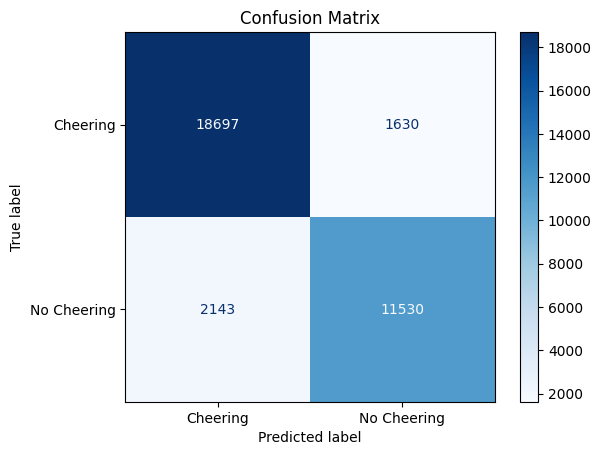

In [42]:
create_confusion_matrix_and_report(model, val_loader)

In [75]:

# y, sample_rate = librosa.load('audios/audio25.mp3', sr=SAMPLE_RATE, mono=True)
# mel_spec = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
# print(mel_spec.shape)
# mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
# mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()
# mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
# mel_spec = mel_spec.unsqueeze(0)
# with torch.no_grad():
#     predictions = model(mel_spec).squeeze().cpu().numpy()
# timestamps = extract_timestamps(predictions, hop_length=HOP_LENGTH, sr=SAMPLE_RATE, merge_threshold=3)
# print("TimeStamps:", timestamps)

###  Function to process variable-length Mel spectrograms with fixed segment size

In [ ]:
def inference_with_fixed_segments(model, audio_path, segment_len, n_mels, hop_length, sr):
    y, sample_rate = librosa.load(audio_path, sr=sr, mono=True)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    print(f"Mel spectrogram shape: {mel_spec.shape}")

    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()

    # Divide the Mel spectrogram into fixed-length segments
    total_time_steps = mel_spec.shape[1]
    num_segments = (total_time_steps + segment_len - 1) // segment_len  # Ceiling division

    predictions = []

    model.eval()
    with torch.no_grad():
        for i in range(num_segments):
            start = i * segment_len
            end = start + segment_len

            segment = mel_spec[:, start:end]
            if segment.shape[1] < segment_len:
                padding = np.zeros((n_mels, segment_len - segment.shape[1]))
                segment = np.concatenate((segment, padding), axis=1)

            segment_tensor = torch.tensor(segment, dtype=torch.float32).unsqueeze(0)
            prediction = model(segment_tensor).squeeze(0).cpu().numpy()
            predictions.append(prediction)

    combined_predictions = np.concatenate(predictions, axis=0)[:total_time_steps]
    return combined_predictions

audio_path = 'audios/audio25.mp3'

with torch.no_grad():
    predictions = inference_with_fixed_segments(
        model=model,
        audio_path=audio_path,
        segment_len=SEGMENT_LEN,
        n_mels=N_MELS,
        hop_length=HOP_LENGTH,
        sr=SAMPLE_RATE
    )

timestamps = extract_timestamps(predictions, hop_length=HOP_LENGTH, sr=SAMPLE_RATE, merge_threshold=3)
print("Timestamps:", timestamps)

Mel spectrogram shape: (64, 7745)
torch.Size([1, 64, 1000])
torch.Size([1, 64, 1000])
torch.Size([1, 64, 1000])
torch.Size([1, 64, 1000])
torch.Size([1, 64, 1000])
torch.Size([1, 64, 1000])
torch.Size([1, 64, 1000])
torch.Size([1, 64, 1000])
Timestamps: [(5.804988662131519, 19.260952380952382), (28.24126984126984, 32.4324716553288), (37.860136054421766, 40.63492063492063)]
